In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] ='0.4'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] ='platform'

import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

import jax.numpy as jnp
from jax import random, vmap, pmap, local_devices, local_device_count

import numpy as np
from jax import image
from tqdm.auto import trange

from models import VAE
from archs import MLP, periodic_encoding
from utils import restore_checkpoint

from configs.default import get_config

import sys
sys.path.append("../")
from cahn_hilliard_discrete.configs import config_64, config_128, config_256
from cahn_hilliard_discrete.models import DiscreteVAE

import matplotlib.pyplot as plt
from matplotlib import style
# style.use('dark_background')
# style.use('Solarize_Light2')

%matplotlib inline

print(local_devices())

2023-01-23 23:47:19.159088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 23:47:19.347406: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 22,  
                      'axes.titlesize': 24,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

In [3]:
data_buf = np.load('../datasets/cahn_hilliard_patterns.npy')
num_examples = data_buf.shape[0]

In [4]:
N = 4096
m = 64
num_channels = 1

resize = lambda x: image.resize(x, shape=(m,m,num_channels), method='bilinear')

key = random.PRNGKey(1)
idx = random.choice(key, num_examples, (N,), replace=False)
test_X = jnp.array(data_buf[idx,...])
test_X = vmap(resize)(test_X)

def get_example(u, X, n):
    u = jnp.flipud(u)
    s = u.reshape(-1,1)
    return u, X, s, jnp.tile(1.0, (X.shape[0],1))

N, m, _, num_channels = test_X.shape

x = np.linspace(0,1,m)
y = np.linspace(0,1,m)
grid_64 = np.meshgrid(x,y)
X = jnp.array(grid_64).T.reshape(-1,2)

# Generate testing samples
key = random.PRNGKey(1)
keys = random.split(key, N)
gen_fn = lambda u: get_example(u, X, m)
u_test_64, y_test_64, s_test_64, w_test_64 = vmap(gen_fn)(test_X)
print('Testing data')
print('u: {}'.format(u_test_64.shape))
print('y: {}'.format(y_test_64.shape))
print('s: {}'.format(s_test_64.shape))
print('w: {}'.format(w_test_64.shape))

Testing data
u: (4096, 64, 64, 1)
y: (4096, 4096, 2)
s: (4096, 4096, 1)
w: (4096, 4096, 1)


In [5]:
N = 4096
m = 128
num_channels = 1

resize = lambda x: image.resize(x, shape=(m,m,num_channels), method='bilinear')

key = random.PRNGKey(1)
idx = random.choice(key, num_examples, (N,), replace=False)
test_X = jnp.array(data_buf[idx,...])
test_X = vmap(resize)(test_X)

def get_example(u, X, n):
    u = jnp.flipud(u)
    s = u.reshape(-1,1)
    return u, X, s, jnp.tile(1.0, (X.shape[0],1))

N, m, _, num_channels = test_X.shape

x = np.linspace(0,1,m)
y = np.linspace(0,1,m)
grid_128 = np.meshgrid(x,y)
X = jnp.array(grid_128).T.reshape(-1,2)

# Generate testing samples
key = random.PRNGKey(1)
keys = random.split(key, N)
gen_fn = lambda u: get_example(u, X, m)
u_test_128, y_test_128, s_test_128, w_test_128 = vmap(gen_fn)(test_X)
print('Testing data')
print('u: {}'.format(u_test_128.shape))
print('y: {}'.format(y_test_128.shape))
print('s: {}'.format(s_test_128.shape))
print('w: {}'.format(w_test_128.shape))

Testing data
u: (4096, 128, 128, 1)
y: (4096, 16384, 2)
s: (4096, 16384, 1)
w: (4096, 16384, 1)


In [6]:
N = 4096
m = 256
num_channels = 1

resize = lambda x: image.resize(x, shape=(m,m,num_channels), method='bilinear')

key = random.PRNGKey(1)
idx = random.choice(key, num_examples, (N,), replace=False)
test_X = jnp.array(data_buf[idx,...])
test_X = vmap(resize)(test_X)

def get_example(u, X, n):
    u = jnp.flipud(u)
    s = u.reshape(-1,1)
    return u, X, s, jnp.tile(1.0, (X.shape[0],1))

N, m, _, num_channels = test_X.shape

x = np.linspace(0,1,m)
y = np.linspace(0,1,m)
grid_256 = np.meshgrid(x,y)
X = jnp.array(grid_256).T.reshape(-1,2)

# Generate testing samples
key = random.PRNGKey(1)
keys = random.split(key, N)
gen_fn = lambda u: get_example(u, X, m)
u_test_256, y_test_256, s_test_256, w_test_256 = vmap(gen_fn)(test_X)
print('Testing data')
print('u: {}'.format(u_test_256.shape))
print('y: {}'.format(y_test_256.shape))
print('s: {}'.format(s_test_256.shape))
print('w: {}'.format(w_test_256.shape))

Testing data
u: (4096, 256, 256, 1)
y: (4096, 65536, 2)
s: (4096, 65536, 1)
w: (4096, 65536, 1)


In [7]:
# Load trained models
config_1 = get_config()
model_1 = VAE(config_1)
model_1 = restore_checkpoint(model_1, '../checkpoints/ch_ConcatDecoder_h256_eps64_beta1e-4_checkpoint_20000')

config_2 = config_64.get_config()
model_2 = DiscreteVAE(config_2)
model_2 = restore_checkpoint(model_2, '../checkpoints/ch_dVAE_64_beta1e-4_checkpoint_20000')

config_3 = config_128.get_config()
model_3 = DiscreteVAE(config_3)
model_3 = restore_checkpoint(model_3, '../checkpoints/ch_dVAE_128_beta1e-4_checkpoint_20000')

config_4 = config_256.get_config()
model_4 = DiscreteVAE(config_4)
model_4 = restore_checkpoint(model_4, '../checkpoints/ch_dVAE_256_beta1e-4_checkpoint_20000')


                            DiscreteOperator Summary                            
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ DiscreteOper… │ -             │ float32[64,… │               │
│               │               │ float32[1,64… │              │               │
│               │               │ - float32[64] │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ encoder       │ ConvEncoder   │ -             │ -            │               │
│               │               │ float32[1,64… │ float32[64]  │               │
│               │               │ - float32[64] │ - float32[]  │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ encoder/Gaus… │ GaussianC

In [8]:
# Test reconstructions
num_samples = 8
key = random.PRNGKey(123)
idx = random.choice(key, N, (num_samples,), replace=False)
eps_test = random.normal(key, (num_samples, config_1.eps_dim))

# 64x64
pred_fn_1 = lambda params: model_1.state.apply_fn(params, u_test_64[idx,...], y_test_64[idx,...], eps_test)
pred_fn_2 = lambda params: model_2.state.apply_fn(params, u_test_64[idx,...], eps_test)

s_pred_1_64 = pmap(pred_fn_1)(model_1.state.params)[0,...]
s_pred_2_64 = pmap(pred_fn_2)(model_2.state.params)[0,...]

# 128x128
pred_fn_1 = lambda params: model_1.state.apply_fn(params, u_test_64[idx,...], y_test_128[idx,...], eps_test)
pred_fn_3 = lambda params: model_3.state.apply_fn(params, u_test_128[idx,...], eps_test)

s_pred_1_128 = pmap(pred_fn_1)(model_1.state.params)[0,...]
s_pred_3_128 = pmap(pred_fn_3)(model_3.state.params)[0,...]

# 256x256
pred_fn_1 = lambda params: model_1.state.apply_fn(params, u_test_64[idx,...], y_test_256[idx,...], eps_test)
pred_fn_4 = lambda params: model_4.state.apply_fn(params, u_test_256[idx,...], eps_test)

s_pred_1_256 = pmap(pred_fn_1)(model_1.state.params)[0,...]
s_pred_4_256 = pmap(pred_fn_4)(model_4.state.params)[0,...]

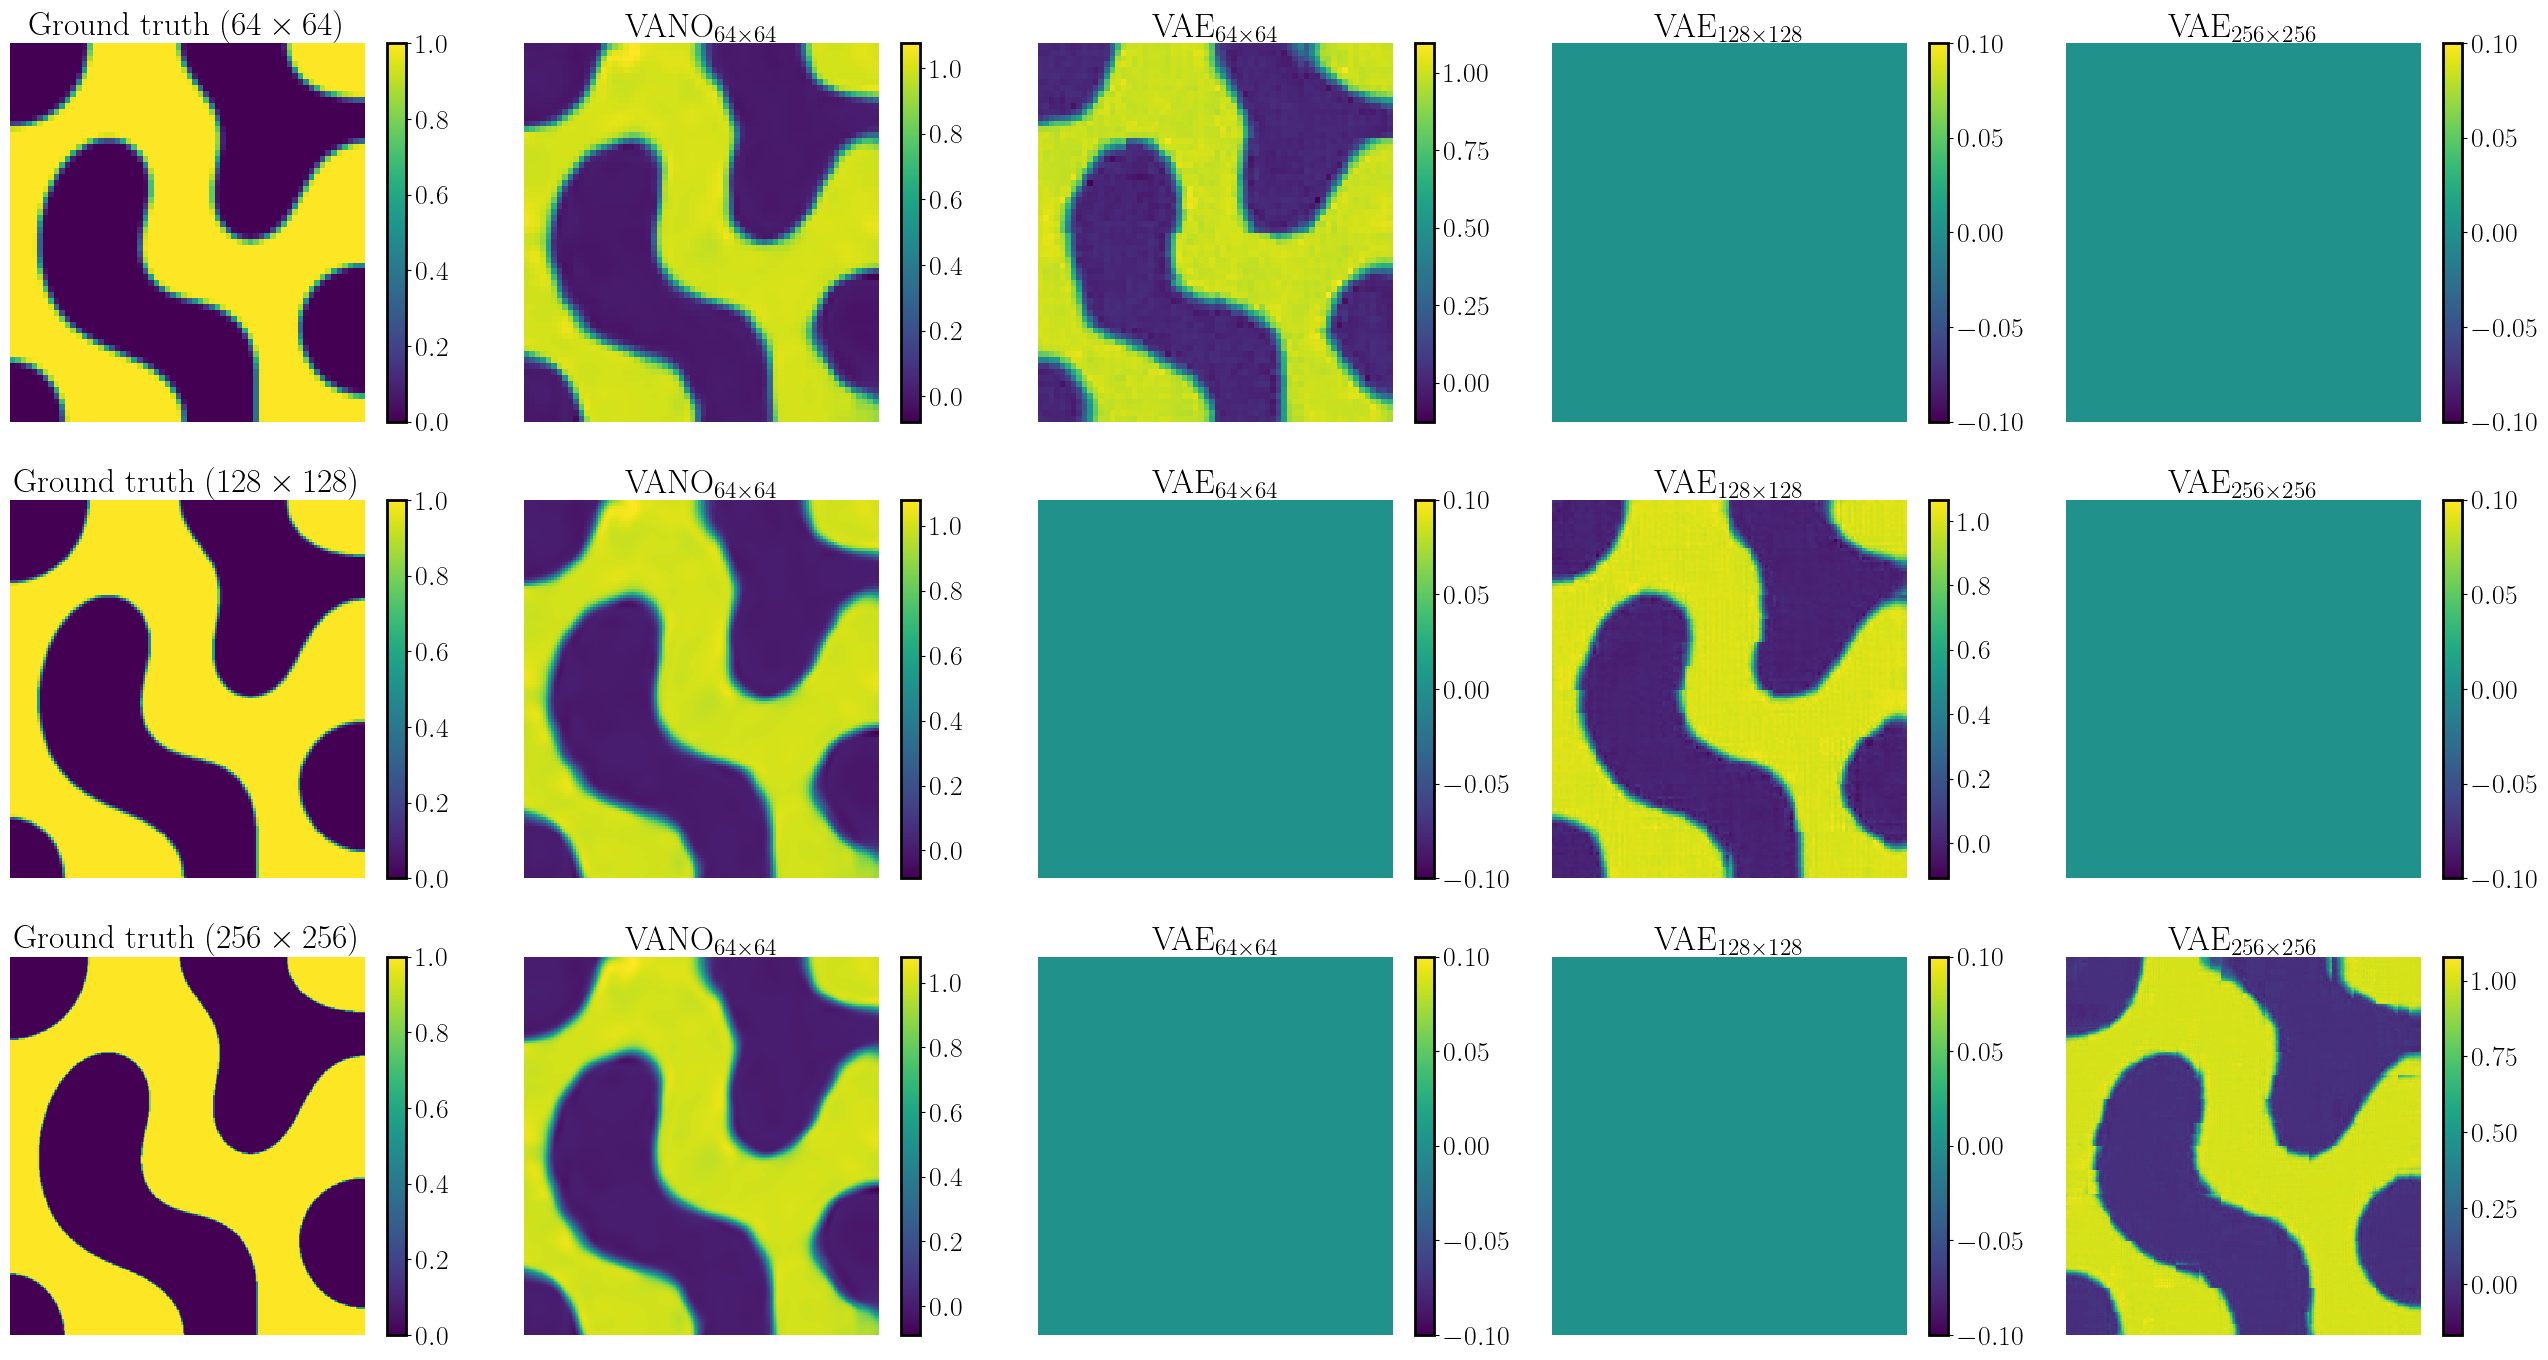

In [9]:
index = 6

plt.figure(figsize=(26, 14))
# 64x64 GT
plt.subplot(3, 5, 1)
plt.pcolor(grid_64[0], grid_64[1], s_test_64[idx[index],...].reshape(64,64).T)
plt.colorbar()
plt.axis('off')
plt.title(r'Ground truth ($64\times 64$)')
# 64x64 VANO
plt.subplot(3, 5, 2)
plt.pcolor(grid_64[0], grid_64[1], s_pred_1_64[index,...].reshape(64,64).T)
plt.colorbar()
plt.axis('off')
plt.title(r'VANO$_{64\times 64}$')
# 64x64 VAE
plt.subplot(3, 5, 3)
plt.pcolor(grid_64[0], grid_64[1], s_pred_2_64[index,...].reshape(64,64).T)
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{64\times 64}$')
# 128x128 VAE
plt.subplot(3, 5, 4)
plt.pcolor(grid_64[0], grid_64[1], jnp.zeros((64,64)))
# plt.text(0.5,0.5,'N/A', bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1})
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{128\times 128}$')
# 256x256 VAE
plt.subplot(3, 5, 5)
plt.pcolor(grid_64[0], grid_64[1], jnp.zeros((64,64)))
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{256\times 256}$')

# 128x128 GT
plt.subplot(3, 5, 6)
plt.pcolor(grid_128[0], grid_128[1], s_test_128[idx[index],...].reshape(128,128).T)
plt.colorbar()
plt.axis('off')
plt.title(r'Ground truth ($128\times 128$)')
# 64x64 VANO
plt.subplot(3, 5, 7)
plt.pcolor(grid_128[0], grid_128[1], s_pred_1_128[index,...].reshape(128,128).T)
plt.colorbar()
plt.axis('off')
plt.title(r'VANO$_{64\times 64}$')
# 64x64 VAE
plt.subplot(3, 5, 8)
plt.pcolor(grid_128[0], grid_128[1], jnp.zeros((128,128)))
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{64\times 64}$')
# 128x128 VAE
plt.subplot(3, 5, 9)
plt.pcolor(grid_128[0], grid_128[1], s_pred_3_128[index,...].reshape(128,128).T)
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{128\times 128}$')
# 256x256 VAE
plt.subplot(3, 5, 10)
plt.pcolor(grid_128[0], grid_128[1], jnp.zeros((128,128)))
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{256\times 256}$')

# 256x256 GT
plt.subplot(3, 5, 11)
plt.pcolor(grid_256[0], grid_256[1], s_test_256[idx[index],...].reshape(256,256).T)
plt.colorbar()
plt.axis('off')
plt.title(r'Ground truth ($256\times 256$)')
# 64x64 VANO
plt.subplot(3, 5, 12)
plt.pcolor(grid_256[0], grid_256[1], s_pred_1_256[index,...].reshape(256,256).T)
plt.colorbar()
plt.axis('off')
plt.title(r'VANO$_{64\times 64}$')
# 64x64 VAE
plt.subplot(3, 5, 13)
plt.pcolor(grid_256[0], grid_256[1], jnp.zeros((256,256)))
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{64\times 64}$')
# 128x128 VAE
plt.subplot(3, 5, 14)
plt.pcolor(grid_256[0], grid_256[1], jnp.zeros((256,256)))
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{128\times 128}$')
# 256x256 VAE
plt.subplot(3, 5, 15)
plt.pcolor(grid_256[0], grid_256[1], s_pred_4_256[index,...].reshape(256,256).T)
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{256\times 256}$')

plt.tight_layout()
plt.savefig('./figures/test_reconstructions_comparisons.png', dpi=300)
plt.show()

In [10]:
# Generate samples
run_idx = 0
key = random.PRNGKey(run_idx)

num_samples = 16
batch_size = 2
num_devices = local_device_count()
num_steps = num_samples // (batch_size*num_devices)

# 64x64
sample_fn_1 = lambda params, eps: model_1.state.decode_fn(params, eps, y_test_64[:batch_size,...])
sample_fn_2 = lambda params, eps: model_2.state.decode_fn(params, eps)

samples_1_64 = []
samples_2_64 = []
for i in trange(num_steps):
    key, subkey = random.split(key)
    eps_test = random.normal(subkey, (num_devices, batch_size, config_1.eps_dim))
    samples_1_64.append(pmap(sample_fn_1, in_axes=(0,0))(model_1.state.params, eps_test))
    samples_2_64.append(pmap(sample_fn_2, in_axes=(0,0))(model_2.state.params, eps_test))
samples_1_64 = jnp.array(samples_1_64).reshape(num_samples,64,64,num_channels)
samples_2_64 = jnp.array(samples_2_64).reshape(num_samples,64,64,num_channels)

# 128x128
sample_fn_1 = lambda params, eps: model_1.state.decode_fn(params, eps, y_test_128[:batch_size,...])
sample_fn_3 = lambda params, eps: model_3.state.decode_fn(params, eps)

samples_1_128 = []
samples_3_128 = []
for i in trange(num_steps):
    key, subkey = random.split(key)
    eps_test = random.normal(key, (num_devices, batch_size, config_1.eps_dim))
    samples_1_128.append(pmap(sample_fn_1, in_axes=(0,0))(model_1.state.params, eps_test))
    samples_3_128.append(pmap(sample_fn_3, in_axes=(0,0))(model_3.state.params, eps_test))
samples_1_128 = jnp.array(samples_1_128).reshape(num_samples,128,128,num_channels)
samples_3_128 = jnp.array(samples_3_128).reshape(num_samples,128,128,num_channels)

# 256x256
sample_fn_1 = lambda params, eps: model_1.state.decode_fn(params, eps, y_test_256[:batch_size,...])
sample_fn_4 = lambda params, eps: model_4.state.decode_fn(params, eps)

samples_1_256 = []
samples_4_256 = []
for i in trange(num_steps):
    key, subkey = random.split(key)
    eps_test = random.normal(key, (num_devices, batch_size, config_1.eps_dim))
    samples_1_256.append(pmap(sample_fn_1, in_axes=(0,0))(model_1.state.params, eps_test))
    samples_4_256.append(pmap(sample_fn_4, in_axes=(0,0))(model_4.state.params, eps_test))
samples_1_256 = jnp.array(samples_1_256).reshape(num_samples,256,256,num_channels)
samples_4_256 = jnp.array(samples_4_256).reshape(num_samples,256,256,num_channels)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
print(grid_64[0].shape)

(64, 64)


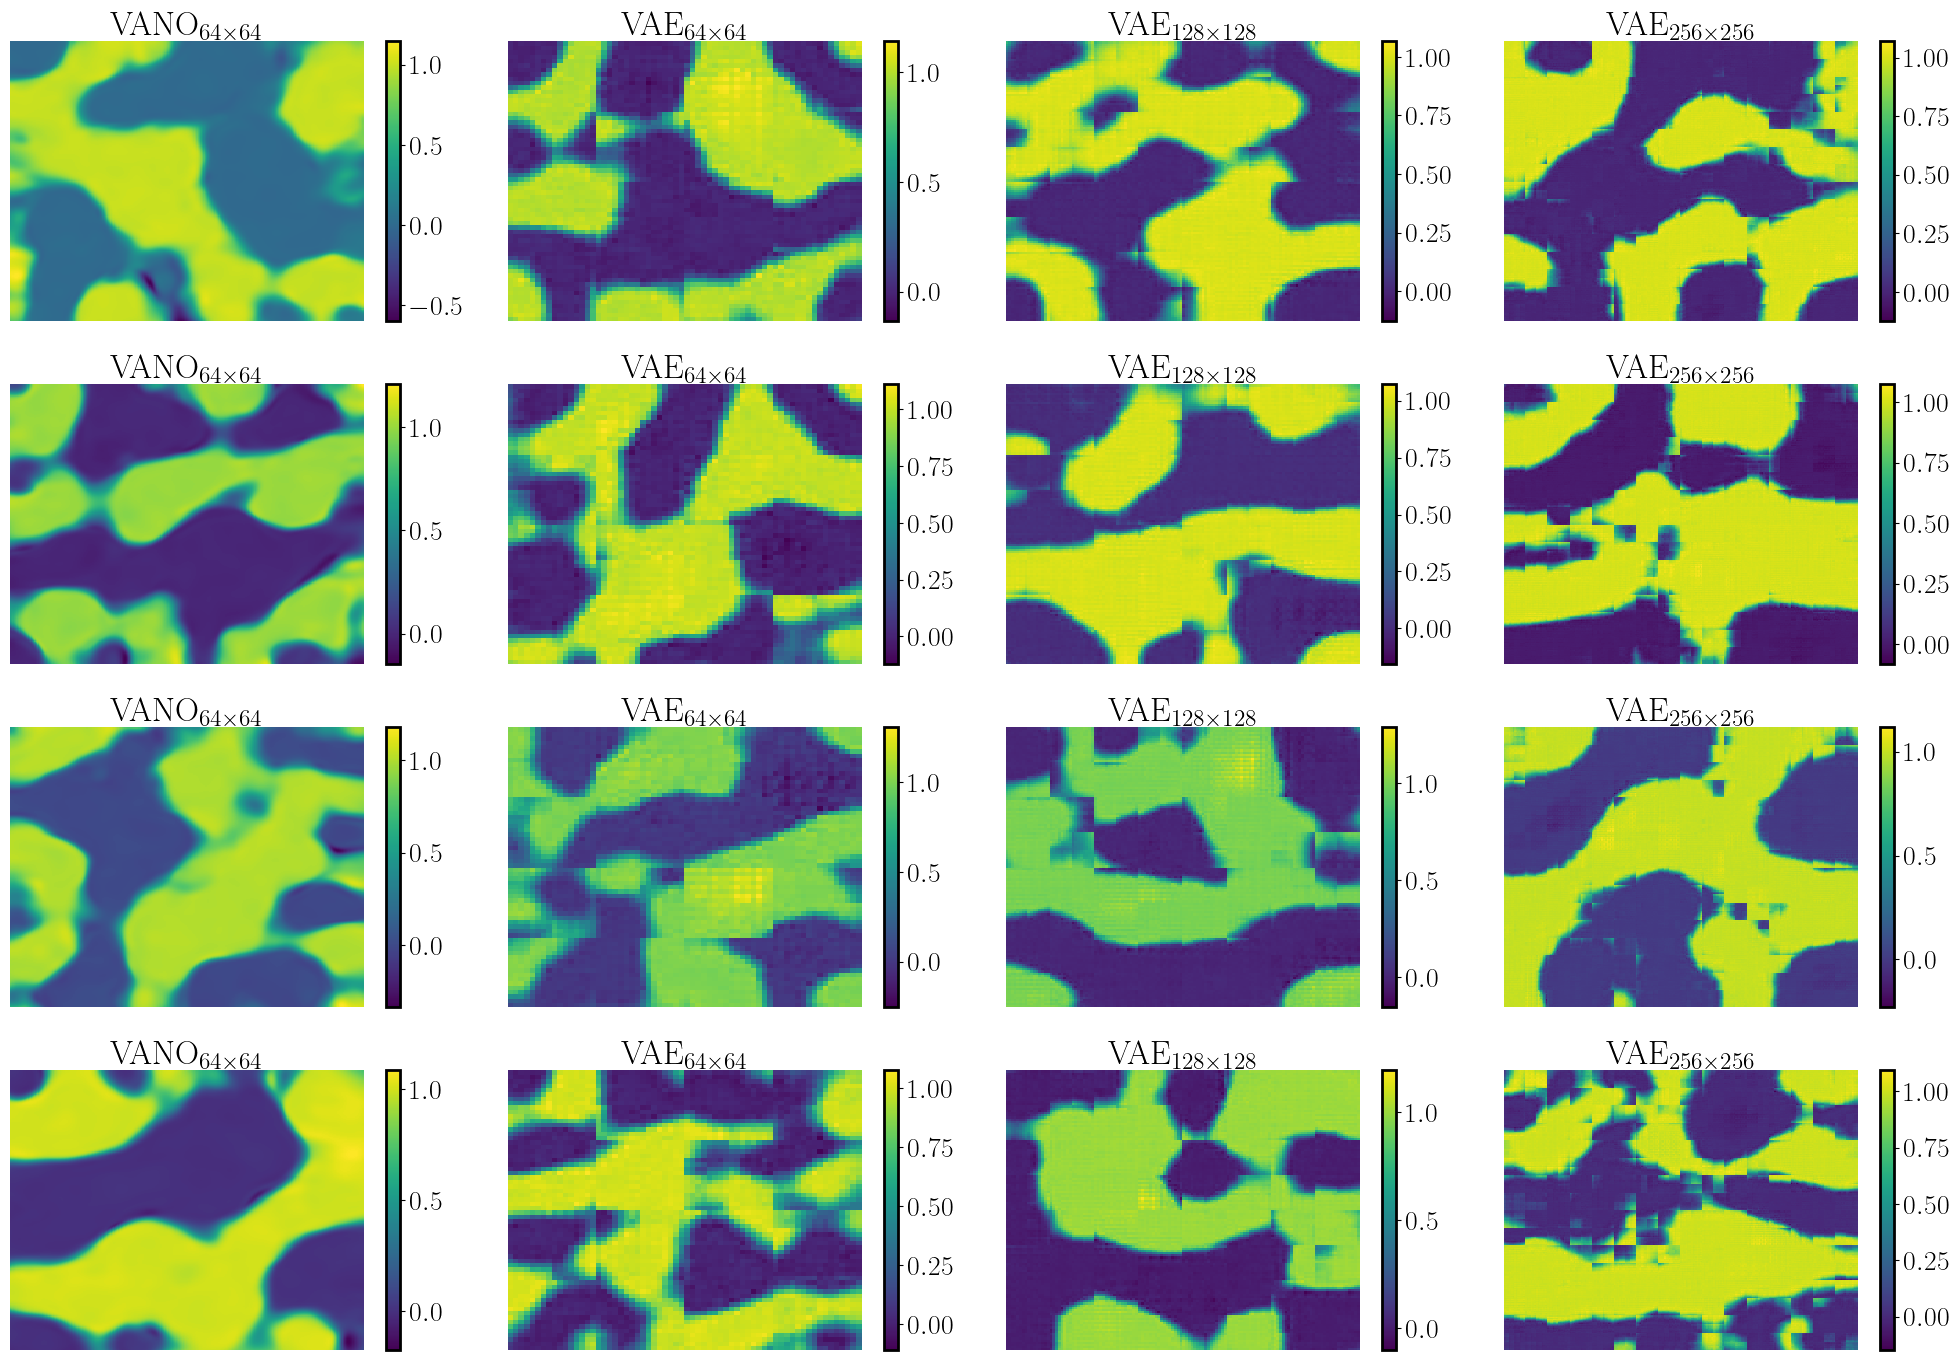

In [20]:
# Plot samples
idx = random.choice(random.PRNGKey(0), num_samples, (4,), replace=False)

plt.figure(figsize=(20, 14))

# 64x64 VANO
plt.subplot(4, 4, 1)
plt.pcolor(grid_256[0], grid_256[1], samples_1_256[idx[0],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VANO$_{64\times 64}$')
# 64x64 VAE
plt.subplot(4, 4, 2)
plt.pcolor(grid_64[0], grid_64[1], samples_2_64[idx[0],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{64\times 64}$')
# 128x128 VAE
plt.subplot(4, 4, 3)
plt.pcolor(grid_128[0], grid_128[1], samples_3_128[idx[0],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{128\times 128}$')
# 256x256 VAE
plt.subplot(4, 4, 4)
plt.pcolor(grid_256[0], grid_256[1], samples_4_256[idx[0],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{256\times 256}$')

# 64x64 VANO
plt.subplot(4, 4, 5)
plt.pcolor(grid_256[0], grid_256[1], samples_1_256[idx[1],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VANO$_{64\times 64}$')
# 64x64 VAE
plt.subplot(4, 4, 6)
plt.pcolor(grid_64[0], grid_64[1], samples_2_64[idx[1],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{64\times 64}$')
# 128x128 VAE
plt.subplot(4, 4, 7)
plt.pcolor(grid_128[0], grid_128[1], samples_3_128[idx[1],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{128\times 128}$')
# 256x256 VAE
plt.subplot(4, 4, 8)
plt.pcolor(grid_256[0], grid_256[1], samples_4_256[idx[1],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{256\times 256}$')

# 64x64 VANO
plt.subplot(4, 4, 9)
plt.pcolor(grid_256[0], grid_256[1], samples_1_256[idx[2],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VANO$_{64\times 64}$')
# 64x64 VAE
plt.subplot(4, 4, 10)
plt.pcolor(grid_64[0], grid_64[1], samples_2_64[idx[2],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{64\times 64}$')
# 128x128 VAE
plt.subplot(4, 4, 11)
plt.pcolor(grid_128[0], grid_128[1], samples_3_128[idx[2],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{128\times 128}$')
# 256x256 VAE
plt.subplot(4, 4, 12)
plt.pcolor(grid_256[0], grid_256[1], samples_4_256[idx[2],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{256\times 256}$')

# 64x64 VANO
plt.subplot(4, 4, 13)
plt.pcolor(grid_256[0], grid_256[1], samples_1_256[idx[3],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VANO$_{64\times 64}$')
# 64x64 VAE
plt.subplot(4, 4, 14)
plt.pcolor(grid_64[0], grid_64[1], samples_2_64[idx[3],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{64\times 64}$')
# 128x128 VAE
plt.subplot(4, 4, 15)
plt.pcolor(grid_128[0], grid_128[1], samples_3_128[idx[3],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{128\times 128}$')
# 256x256 VAE
plt.subplot(4, 4, 16)
plt.pcolor(grid_256[0], grid_256[1], samples_4_256[idx[3],...,0])
plt.colorbar()
plt.axis('off')
plt.title(r'VAE$_{256\times 256}$')

plt.tight_layout()
plt.savefig('./figures/samples_comparisons.png', dpi=300)
plt.show()

In [13]:
def compute_mmd(X, Y):
    
    def MMD(X, Y, k):
        n = X.shape[0]
        m = Y.shape[0]
        kXX = k(X,X)
        kYY = k(Y,Y)
        kXY = k(X,Y)
        Xterm = 1./(n*(n-1))*jnp.sum(kXX)
        Yterm = 1./(m*(m-1))*jnp.sum(kYY)
        XYterm = 1./(n*m)*jnp.sum(kXY)
        return Xterm + Yterm - 2*XYterm

    dim = X.shape[1]**2
    kernelfunc = lambda x, y, sigmasq: jnp.exp(- 1./(2*sigmasq*dim) * jnp.dot(x-y, x-y))

    # Define sweep range and containers
    sigmasqs = jnp.logspace(-2,2,100)
    def get_mmds(X, Y, sigmasq):
        kernel = lambda x, y: kernelfunc(x, y, sigmasq)
        k = vmap(vmap(kernel, in_axes=(None, 0)), in_axes=(0, None))
        mmd = MMD(X, Y, k)
        return mmd

    mmds = vmap(get_mmds, in_axes=(None,None,0))(X.reshape(num_samples,-1), 
                                                 Y.reshape(num_samples,-1),
                                                 sigmasqs)
    return mmds    

In [14]:
# # 64x64
# targets = s_test_64[run_idx*num_samples:(run_idx+1)*num_samples,...].reshape(num_samples,64,64,1)
# mmds_1_64 = compute_mmd(samples_1_64, targets)
# mmds_2_64 = compute_mmd(samples_2_64, targets)

# # 128x128
# targets = s_test_128[run_idx*num_samples:(run_idx+1)*num_samples,...].reshape(num_samples,128,128,1)
# mmds_1_128 = compute_mmd(samples_1_128, targets)
# mmds_3_128 = compute_mmd(samples_3_128, targets)

# # 256x256
# targets = s_test_256[run_idx*num_samples:(run_idx+1)*num_samples,...].reshape(num_samples,256,256,1)
# mmds_1_256 = compute_mmd(samples_1_256, targets)
# mmds_4_256 = compute_mmd(samples_4_256, targets)


In [15]:
# print('64x64 MMD: %e (VANO), %e (VAE)' % (mmds_1_64.max(), mmds_2_64.max()))
# print('128x128 MMD: %e (VANO), %e (VAE)' % (mmds_1_128.max(), mmds_3_128.max()))
# print('256x256 MMD: %e (VANO), %e (VAE)' % (mmds_1_256.max(), mmds_4_256.max()))

In [16]:
# run_idx = 1 
# 64x64 MMD: 6.891832e-03 (VANO), 7.050768e-03 (VAE) (computed using 512 samples)
# 128x128 MMD: 8.298963e-03 (VANO), 6.305724e-03 (VAE) (computed using 512 samples)
# 256x256 MMD: 1.291320e-02 (VANO), 1.053706e-02 (VAE) (computed using 256 samples)

# run_idx = 2
# 64x64 MMD: 7.166535e-03 (VANO), 7.432342e-03 (VAE) (computed using 512 samples)
# 128x128 MMD: 9.198904e-03 (VANO), 6.677181e-03 (VAE) (computed using 512 samples)
# 256x256 MMD: 1.420349e-02 (VANO), 1.043794e-02 (VAE) (computed using 256 samples)

# run_idx = 3
# 64x64 MMD: 6.944090e-03 (VANO), 7.157892e-03 (VAE) (computed using 512 samples)
# 128x128 MMD: 8.414373e-03 (VANO), 5.906075e-03 (VAE) (computed using 512 samples)
# 256x256 MMD: 1.365820e-02 (VANO), 9.833694e-03 (VAE) (computed using 256 samples)

# run_idx = 4
# 64x64 MMD: 6.618947e-03 (VANO), 7.431209e-03 (VAE) (computed using 512 samples)
# 128x128 MMD: 9.231806e-03 (VANO), 6.775796e-03 (VAE) (computed using 512 samples)
# 256x256 MMD: 1.365718e-02 (VANO), 1.010221e-02 (VAE) (computed using 256 samples)

# run_idx = 5
# 64x64 MMD: 7.728726e-03 (VANO), 7.465839e-03 (VAE) (computed using 512 samples)
# 128x128 MMD: 8.960664e-03 (VANO), 6.182551e-03 (VAE) (computed using 512 samples)
# 256x256 MMD: 1.260573e-02 (VANO), 1.052824e-02 (VAE) (computed using 256 samples)

In [17]:
# # 64x64
# data_1 = jnp.array([6.891832e-03, 7.166535e-03, 6.944090e-03, 6.618947e-03, 7.728726e-03])
# data_2 = jnp.array([7.050768e-03, 7.432342e-03, 7.157892e-03, 7.431209e-03, 7.465839e-03])
# print('64x64 VANO MMD: %e pm %e' % (data_1.mean(), data_1.std()))
# print('64x64 VAE MMD: %e pm %e' % (data_2.mean(), data_2.std()))

# # 128x128
# data_1 = jnp.array([8.298963e-03, 9.198904e-03, 8.414373e-03, 9.231806e-03, 8.960664e-03])
# data_3 = jnp.array([6.305724e-03, 6.677181e-03, 5.906075e-03, 6.775796e-03, 6.182551e-03])
# print('128x128 VANO MMD: %e pm %e' % (data_1.mean(), data_1.std()))
# print('128x128 VAE MMD: %e pm %e' % (data_3.mean(), data_3.std()))

# # 256x256
# data_1 = jnp.array([1.291320e-02, 1.420349e-02, 1.365820e-02, 1.365718e-02, 1.260573e-02])
# data_4 = jnp.array([1.053706e-02,1.043794e-02,  9.833694e-03, 1.010221e-02, 1.052824e-02])
# print('256x256 VANO MMD: %e pm %e' % (data_1.mean(), data_1.std()))
# print('256x256 VAE MMD: %e pm %e' % (data_4.mean(), data_4.std()))
